# Total reconstructed energy by CLUE3D per event

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
from hist.stack import Stack

sys.path.append("../..")
from HistogramLib.store import HistogramStore
from HistogramLib.plot_manager import PlotManager
from HistogramLib.bokeh.histogram_widget import *
from hists.parameters import beamEnergies
from hists.store import HistogramId
from bokeh_apps.widgets import *

In [4]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v19'
histStore = HistogramStore(hist_folder, HistogramId)

In [7]:
def getProjected(datatype, beamEnergy):
    return (
        histStore.get(HistogramId("Clus3DClusteredEnergy", "cmssw", datatype))
        .getHistogram(HistogramKind.COUNT)
        [{"beamEnergy":hist.loc(beamEnergy), "mainOrAllTracksters":hist.loc("mainTrackster")}]
        .project("clus3D_energy")
    )

datatypesToPlot = ["data", "sim_proton_v7"]

def getStack(beamEnergy):
    return Stack.from_dict({datatype : getProjected(datatype, beamEnergy) for datatype in datatypesToPlot})

In [8]:
def getMPVLocation(h:hist.Hist):
    """ Get center of bin of most probable value """
    return h.axes[0].centers[np.argmax(h.counts())]

def computeEnergyShift(h_model, h_toScale):
    mpv_model = getMPVLocation(h_model)
    mpv_toScale = getMPVLocation(h_toScale)
    return  mpv_toScale - mpv_model

In [43]:
def plot(stack:hist.stack.Stack, beamEnergy, axData=None, computeEnergyShift=computeEnergyShift, xLim=None):
    for hist in stack:
        if hist.name == "data":
            h_data = hist
        else:
            h_sim = hist
    if axData is None:
        fig, axData = plt.subplots()
    axData.yaxis.set_ticks_position('left')
    axData.set_xlabel("CLUE3D clustered energy (data)")
    axData.set_ylabel("Events (data)")

    hep.histplot(h_data, yerr=False, ax=axData, label="data")

    axIntermediate = axData.twiny()
    axSim = axIntermediate.twinx()
    # need to use this intermediate axis otherwise xlabel at top does not work
    axIntermediate.set_xlabel("CLUE3D clustered energy (simulation)")
    axSim.set_ylabel("Events (Simulation)")
    hep.histplot(h_sim, yerr=False, ax=axSim, color='orange', label=h_sim.name)

    hep.cms.text("Preliminary                     e+ "+str(beamEnergy) + " GeV", pad=0.1)

    if xLim is None:
        xLim = 0.5*beamEnergy,1.1*beamEnergy
    axData.set_xlim(xLim)
    axSim.set_xlim(xLim[0]+computeEnergyShift(h_data, h_sim), xLim[1]+computeEnergyShift(h_data, h_sim))


    lines, labels = axData.get_legend_handles_labels()
    lines2, labels2 = axSim.get_legend_handles_labels()
    axData.legend(lines + lines2, labels + labels2, loc='upper left')

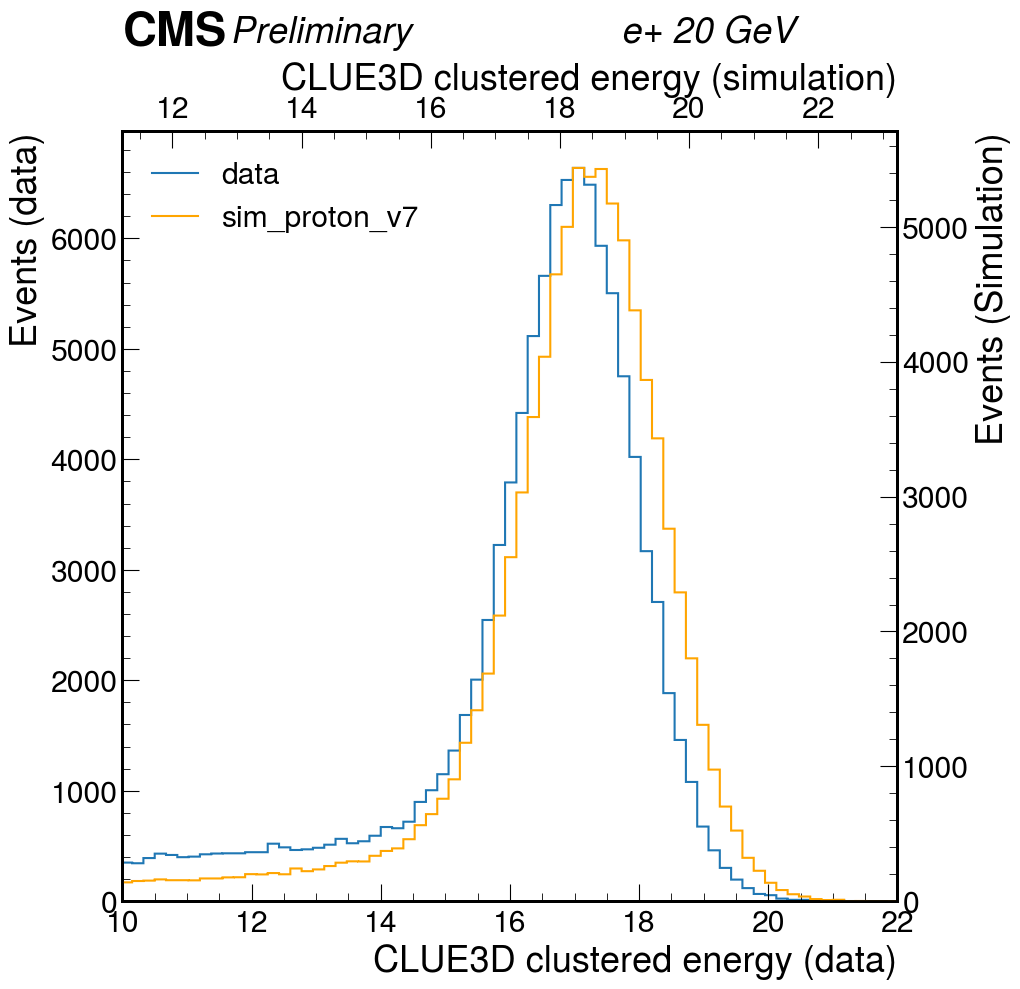

In [44]:
plot(getStack(20), 20)

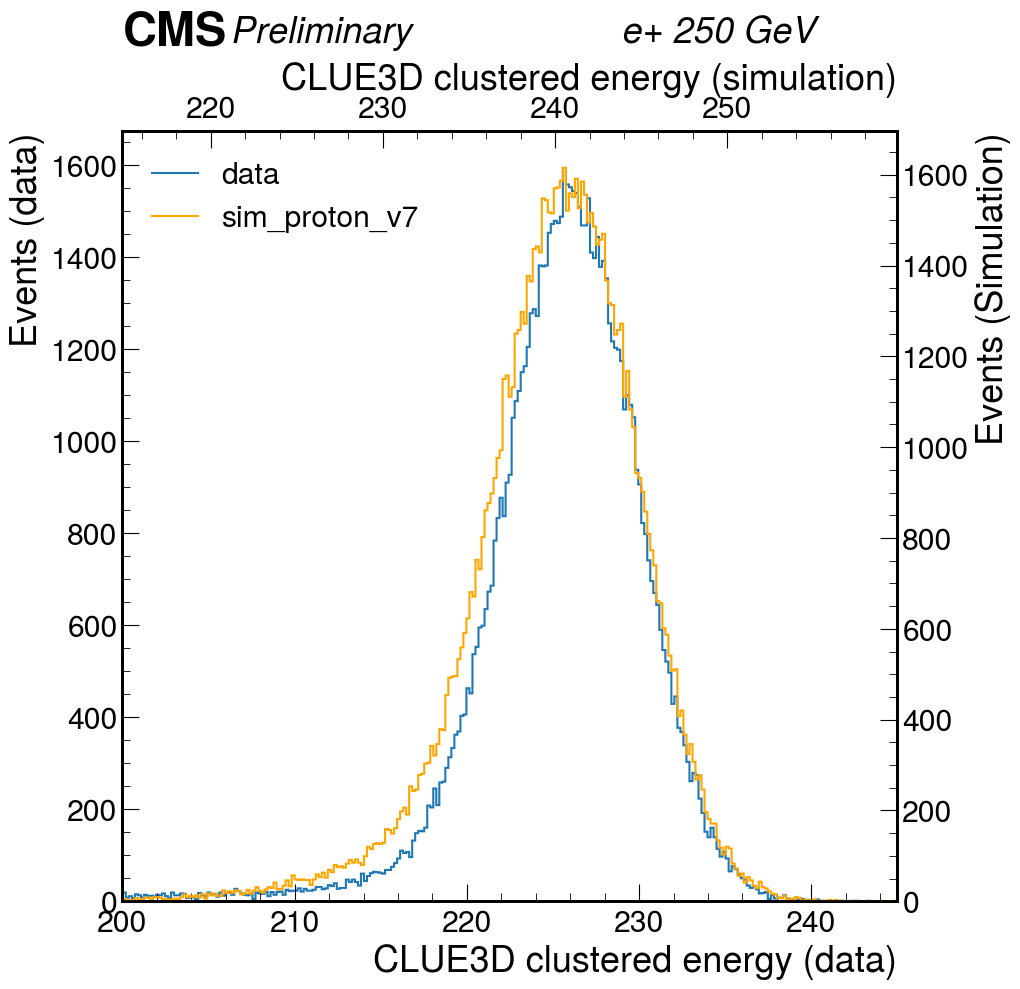

In [47]:
plot(getStack(250), 250, xLim=(200, 245))

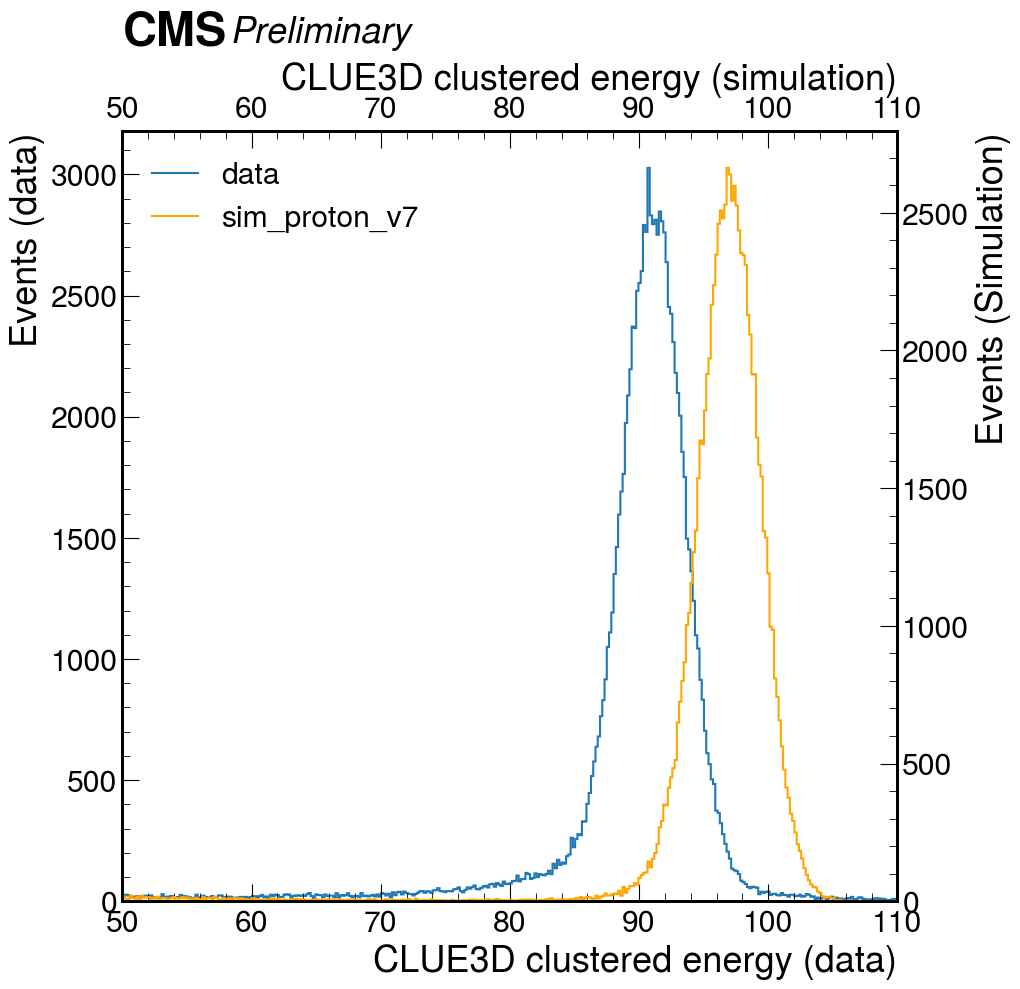

In [10]:
plot(getStack(100), 100, computeEnergyShift=lambda a, b : 0)

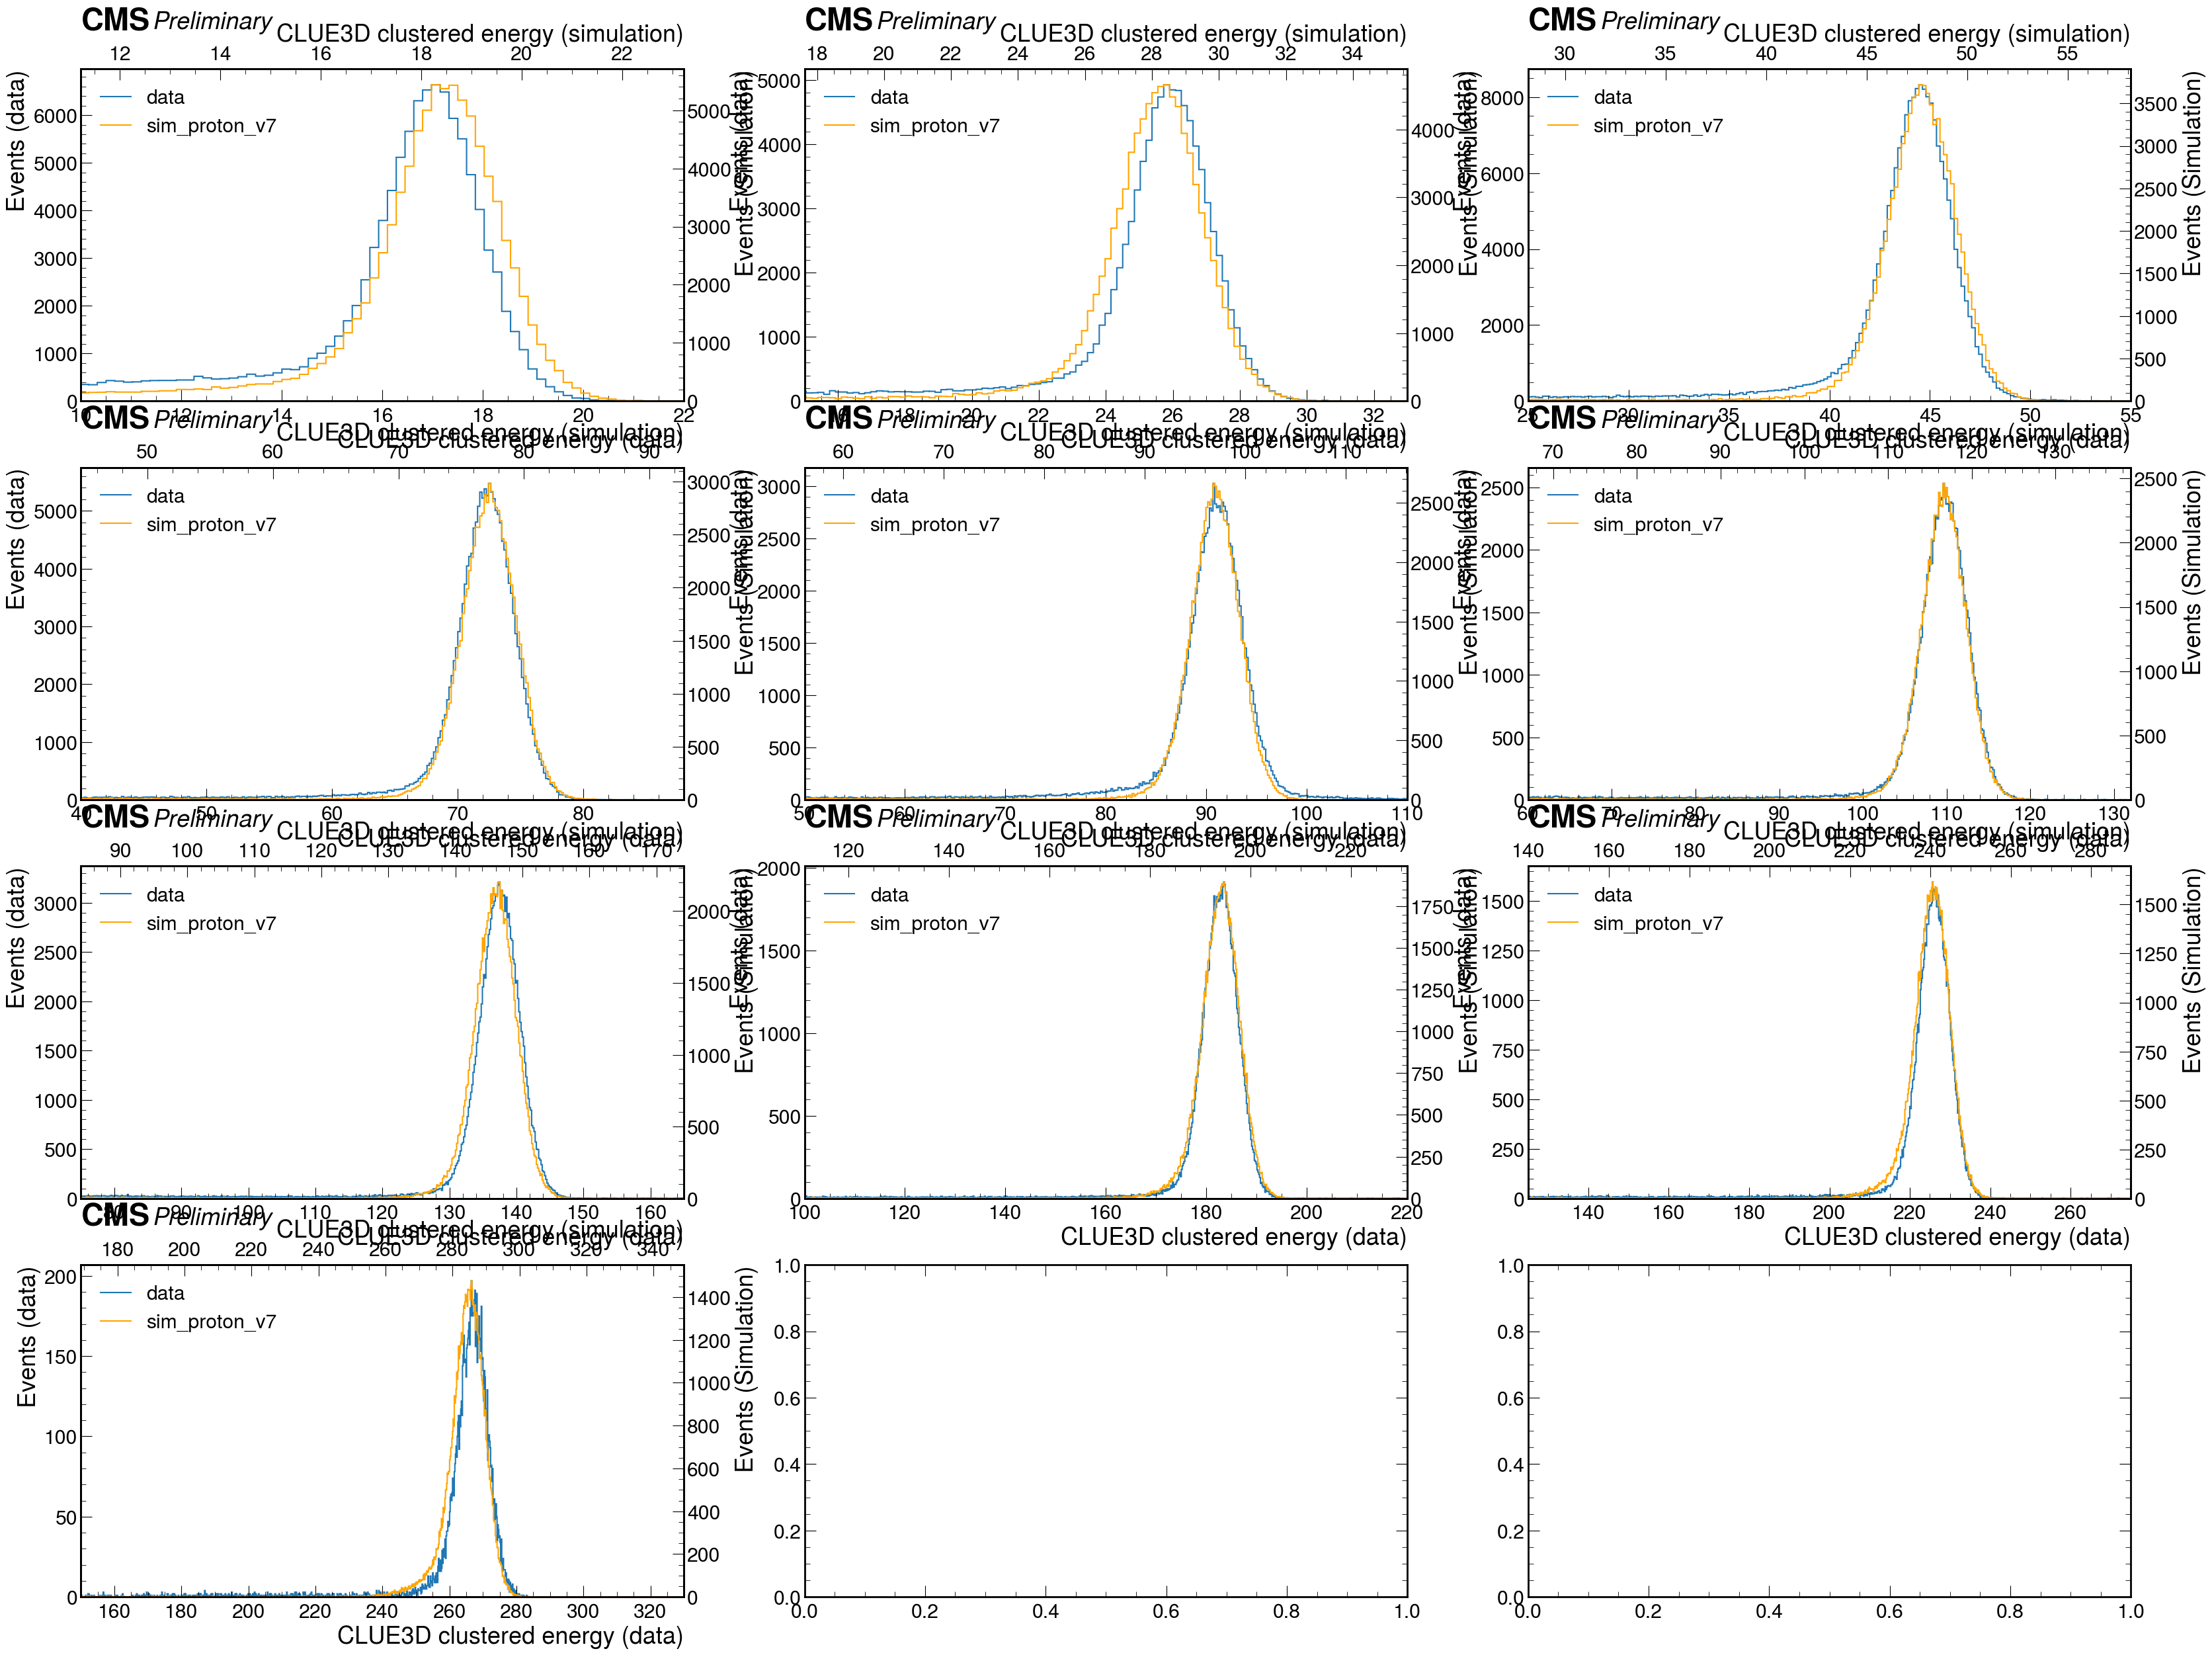

In [24]:
fig, axes = plt.subplots(4, 3, figsize=(40, 30))
for beamEnergy, ax in zip(beamEnergies, axes.flatten()):
    plot(getStack(beamEnergy), beamEnergy, axData=ax)

In [22]:
mpvDiff_perBeamEnergy = []
for beamEnergy in beamEnergies:
    stack = getStack(beamEnergy)
    mpvDiff_perBeamEnergy.append(getMPVLocation(stack[1]) - 1.065*getMPVLocation(stack[0]))
mpvDiff_perBeamEnergy

[0.11593749999999758,
 0.9471875000000018,
 0.2550625000000011,
 0.010062500000017849,
 0.2270625000000024,
 -0.12643749999998022,
 0.16493750000000773,
 -0.726687499999997,
 0.20693750000000932,
 1.745187499999986]

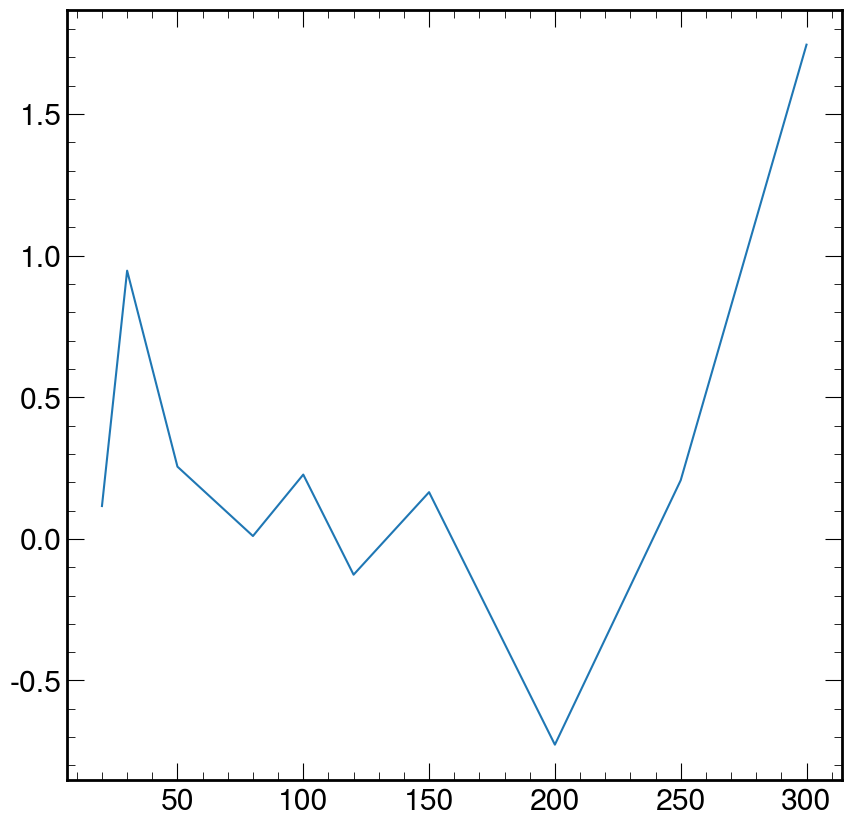

In [23]:
plt.plot(beamEnergies, mpvDiff_perBeamEnergy)